In [1]:
import os
import sys
import time

import numpy as np

from pstools.rambo import dot

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras import activations
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras import backend
from keras.initializers import glorot_uniform

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

2025-11-17 16:11:00.870991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training a Neural Network to approximate amplitudes from pre-generated data ##

The sqaured scattering amplitude (summed and averaged over colour) for $e^+e^- \to$ jets have been evaluated over a flat phase-space generated with the RAMBO algorithm. Various phase-space cuts for the separation of final state 'jets' have been applied using the JADE algorithm. Tree/zero-loop '0L' ($|A^{(0)}|^2$) and one-loop ($2{\rm Re}(A^{(0)*}A^{(1)}|$) amplitudes have been compute using the NJet C++ library (https://bitbucket.org/njet/njet/wiki/Home)

The data consists of 1M phase-space points for processes with 3 or 4 final state jets. The data is given in numpy '.npz' format generated using the 'numpy.savez' command and are labelled as

<code>data/NJdata_\<loop order\>_ee\<n\>j_d\<jade cut\>.npz</code>

where loop order=0L,1L, n=3,4 and jade cut=0.03, 0.02 and 0.01

The data files can be obtained from the url (using wget for example):

`wget http://personalpages.to.infn.it/~badger/njet-data/eejet_data.tar.gz`

# Aims #

To use the tensorflow library to make a simple approximation of the multi-variable amplitude function and test how good of an approximation we get. Try to determine how well we approximate the amplitude point-by-point correlates with the observable cross section

# Step 1: Separate amplitude data and train TensorFlow neural network #

In [2]:
loop = 0
jets = 3
delta_cut = 0.03

In [3]:
NJdata = np.load("data/NJdata_"+str(loop)+"L_ee"+str(jets)+"j_d"+str(delta_cut)+".npz")
print(NJdata.files)

mom_data = NJdata['momenta']
amp_data = NJdata['NJ_vals']

['momenta', 'NJ_vals']


In [4]:
# choose the number of training points (will later be split into NN train/validation set)
n_points = len(amp_data)
print("found", n_points, "data points")

n_training_points = 100000
# choose the number of points for interpolation tests after training
# NB - different from the training/validation split during training
n_test_points = 100000

print("will train/validate on",n_training_points,"then test on",n_test_points)

found 1000000 data points
will train/validate on 100000 then test on 100000


In [5]:
# NB the points are already randomly distributed according to RAMBO
# so we may just slice the array into training/validation and testing
mom_train = mom_data[:n_training_points]
amp_train = amp_data[:n_training_points]

In [6]:
def mean_and_std(myarray, axis=0):
    return np.mean(myarray, axis=axis), np.std(myarray, axis=axis)

In [7]:
def standardize(myarray, ave, std):
    return (myarray-ave)/std

def destandardize(myarray, ave, std):
    return myarray*std+ave

In [8]:
# the standardized momenta cuts out the initial state since it is fixed for e+e- collisions
# NB if we attempted to keep it then dividing by the standard deviation would give division by zero
# momenta[:,2:,:] means take all phase space points but only take momenta 2 to n
# since the array is labelled momenta[i=(1,n_points), j=(1,n_particles), mu=(1,4)]  
mom_ave, mom_std = mean_and_std(mom_train[:,2:,:], axis=0)
mom_stdized = standardize(mom_train[:,2:,:], mom_ave, mom_std)

In [9]:
# alternatively we could use momentum invariants (p_i+p_j+...)^2 as inputs
# 3n-10 of these are independent for an n-particle scattering (masseless) amplitude
# 
def minkowski_dot_matrix(mm):
    g = np.array([1, -1, -1, -1])
    mm_tilde = mm * g
    A = np.einsum('ik,jk->ij', mm_tilde, mm)

    return A

def computeinvariants(mm):
    A = minkowski_dot_matrix(mm)
    inds = np.triu_indices_from(A, k=1)
    
    return A[inds]

inv_train = np.array([computeinvariants(mm) for mm in mom_train])

In [10]:
# as we are have e+e- with fixed centre-of-mass energy the invariant (p0+p1)^2 = 2*p0.p1 is constant and can be eliminated
inv_ave, inv_std = mean_and_std(inv_train[:,1:],axis=0)
inv_stdized = standardize(inv_train[:,1:], inv_ave, inv_std)

In [11]:
# the standardized the ampltide values as well
amp_ave = np.mean(amp_train)
amp_std = np.std(amp_train)
amp_stdized = (amp_train-amp_ave)/amp_std

In [12]:
# now set up Keras model with flattened momenta and invariants as input values
n_final = len(mom_stdized[0])
input_size_mom = n_final*4
input_values_mom = mom_stdized.reshape(-1,input_size_mom)

input_size_inv = len(inv_stdized[0])
input_values_inv = inv_stdized

In [13]:
input_values_mominv = np.concatenate([input_values_mom,input_values_inv], axis=1)

In [14]:
backend.clear_session()

In [15]:
def make_baseline(layers, input_size):
    model = Sequential()
    model.add(Dense(layers[0], input_dim=(input_size), kernel_initializer = glorot_uniform(seed=1)))
    model.add(Activation(activations.tanh))
        
    for layer in range(1, len(layers)):
        model.add(Dense(layers[layer]))
        model.add(Activation(activations.tanh))

    model.add(Dense(1, kernel_initializer = glorot_uniform(seed=len(layers))))
    
    opt = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

callbacks = [
    EarlyStopping(monitor='val_loss', patience=50, min_delta=1e-4, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=0)
]

In [16]:
model = []
n_ensemble = 20
for mm in range(n_ensemble):
    model.append(make_baseline([20,40,20],len(input_values_mominv[0])))

2025-11-17 16:11:12.135843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
history = []
for mm in range(n_ensemble):
    
    print('### model', mm);
    
    
    in_mominv_tr, in_mominv_val, out_mominv_tr, out_mominv_val = train_test_split(
        input_values_mominv, amp_stdized, test_size=0.2)
    
    st = time.time();

    history.append(model[mm].fit(
        in_mominv_tr, out_mominv_tr,
        validation_data=(in_mominv_val, out_mominv_val),
        batch_size=1024, epochs=2000, verbose=0,
        callbacks=callbacks
    ))

    et = time.time()
    print('trained in ',(et-st)/60.,' mins')
    print(f'Best case loss: {callbacks[0].best}')

### model 0

Epoch 397: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 436: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 472: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 485: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 502: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 512: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 522: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch: 492.
Epoch 542: early stopping
trained in  1.8695878346761068  mins
Best case loss: 0.02147492952644825
### model 1

Epoch 479: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 502: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 513: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 527: ReduceLROnPlateau reducing learni

(0.0, 1000.0)

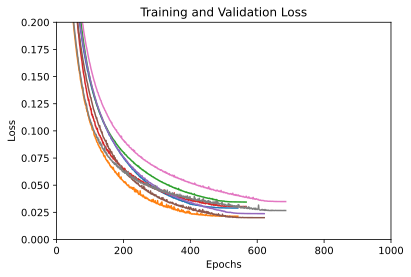

In [18]:
# Access the loss values from the training history.
for mm in range(n_ensemble):
    train_loss = history[mm].history['loss']
    val_loss = history[mm].history['val_loss']

    # Create a plot of the training and validation loss over epochs.
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, label='Training Loss '+str(mm))
    plt.plot(epochs, val_loss, label='Validation Loss '+str(mm))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,0.2)
plt.xlim(0,1000)

# Step 2: Test the model on unseen data

In [19]:
mom_test = mom_data[n_training_points:n_training_points+n_test_points]

In [20]:
mom_test_stdized = standardize(mom_test[:,2:,:],mom_ave, mom_std).reshape(-1,input_size_mom)

inv_test = np.array([computeinvariants(mm) for mm in mom_test])
inv_test_stdized = standardize(inv_test[:,1:], inv_ave, inv_std)

mominv_test_stdized = np.concatenate([mom_test_stdized,inv_test_stdized], axis=1)

In [21]:
amp_preds = [np.array(
    destandardize(model[mm].predict(mominv_test_stdized), amp_ave, amp_std)
).reshape(-1) for mm in range(n_ensemble)]

3125/3125 [==============================] - 3s 1ms/step


In [22]:
amp_pred = np.mean(amp_preds,axis=0)
amp_pred_err = np.std(amp_preds,axis=0)

In [23]:
amp_test = amp_data[n_training_points:n_training_points+n_test_points]

In [24]:
acc = 2.*(amp_pred-amp_test)/(amp_pred+amp_test)

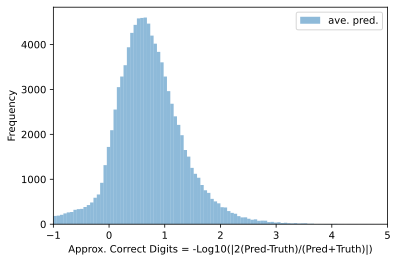

In [25]:
logacc = -np.log10(abs(acc))

mybins = np.histogram_bin_edges(logacc, bins=100, range=(-1,5))
plt.hist(logacc, density=False, bins=mybins, alpha=0.5, label='ave. pred.')
plt.xlim([-1,5])
plt.xlabel('Approx. Correct Digits = -Log10(|2(Pred-Truth)/(Pred+Truth)|)')
plt.ylabel('Frequency');
plt.legend()

# Step 3: Check the total cross-section #

Let's now check the cross section which for a RAMBO phase-space is defined as (Leading Order)

$\sigma = 1/N_{trials} \sum_p |A(p)|^2$

where $N_{trials}$ is total number of random samples of momenta generated. Since JADE cuts have been applied the number of trials will not be equal to the number of phase-space points. This information was not given with the data set so we won't get the normalisation of the cross-section correct but the convergence cross-section can be tested using the mean value

$\hat{\sigma} = \langle |A(p)|^2 \rangle_p$

with the error estimate given by the standard deviation divided by the square root of the number of points.

In [26]:
# total cross section for the test sample
print("sigma_test = ",np.mean(amp_test),"+/-",np.std(amp_test)/np.sqrt(len(amp_test)))
sigma_ref = np.mean(amp_test)

sigma_test =  0.036326967138540035 +/- 0.00026860418897737507


In [27]:
amp_pred_max = amp_pred+amp_pred_err
amp_pred_min = amp_pred-amp_pred_err

In [28]:
# total cross section comparing 'MC statistical error' with the error associated with the ensemble
# note the MC error is much smaller that the range given using the SD of the ensemble
print("sigma_pred = ",np.mean(amp_pred),"+/-",np.std(amp_pred)/np.sqrt(len(amp_pred)))
print("sigma_pred = ",np.mean(amp_pred),"+",np.mean(amp_pred_max)-np.mean(amp_pred),"-",np.mean(amp_pred)-np.mean(amp_pred_min))

sigma_pred =  0.036240462 +/- 0.00025972995090729805
sigma_pred =  0.036240462 + 0.0070124194 - 0.0070124157


In [29]:
# Now plot the cross-section cumilatively for the test set and models 1,2
stepsize = 1000
xs_NJ  = [[np.mean(amp_test[0:stepsize*i]), np.std(amp_test[0:stepsize*i])] for i in range(1,int(n_test_points/stepsize))]
xs_NN = [[np.mean(amp_pred[0:stepsize*i]), np.std(amp_pred[0:stepsize*i])] for i in range(1,int(n_test_points/stepsize))]
xs_NNerr = [[np.mean(amp_pred_err[0:stepsize*i]), np.std(amp_pred_err[0:stepsize*i])] for i in range(1,int(n_test_points/stepsize))]

xs_NJ = np.array(xs_NJ)
xs_NN = np.array(xs_NN)
xs_NNerr = np.array(xs_NNerr)

In [30]:
# This notation takes every 100 entries in the cumalative less so we don't plot so many points
plotdata1 = xs_NJ[:,0]
plotdata2 = xs_NN[:,0]
plotdata2err = xs_NNerr[:,0]

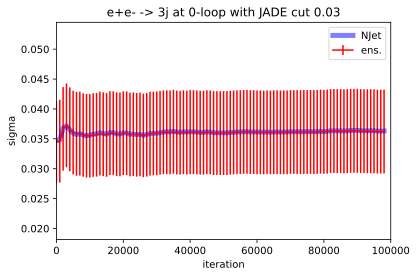

In [76]:
plt.plot(stepsize*np.array(range(len(plotdata1))), plotdata1, 'b-', lw=5, alpha=0.5, label='NJet')
plt.errorbar(stepsize*np.array(range(len(plotdata2))), plotdata2, yerr=plotdata2err, fmt='r-', label='ens.')
plt.xlim([0,n_test_points])
plt.ylim([sigma_ref*(1.-0.5),sigma_ref*(1.+0.5)])
plt.ylabel('sigma')
plt.xlabel('iteration');
plt.title(r'e+e- -> '+str(jets)+'j at '+str(loop)+'-loop with JADE cut '+str(delta_cut))
plt.legend()

We may also look at the size of the amplitude as a function of the accuracy of the predicitions

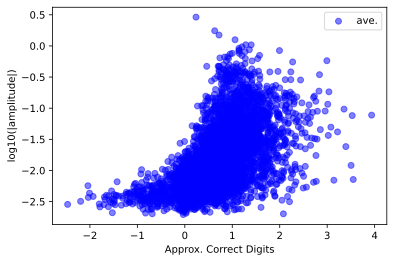

In [32]:
idx = np.random.choice(len(amp_test), size=5000, replace=False)

plt.scatter(logacc[idx],np.log10(np.abs(amp_test[idx])),color='blue',alpha=0.5, label='ave.')
plt.xlabel('Approx. Correct Digits')
plt.ylabel('log10(|amplitude|)');
plt.legend()

# Step 4: Try heteroscedastic loss function #

In this section we consider a modified loss function and attempt to learn both the mean value $\mu$ and the variance $\sigma^2$ simultaneously. The heteroscedastic loss function takes the training data $y$ and current values for the mean $\mu$ and variance $\sigma^2$. The loss function takes the form of an MSE component, $(y-\mu)^2$, and a negative log likelihood component $log(\sigma^2)$. There is some flexibility on the exact choice, commonly it is written as

$$
\mathcal{L} = \frac{(y-\mu)^2}{2\sigma^2} + \frac{1}{2}log(\sigma^2)
$$

It appears training with type of loss is sensitive. ReLU activations are preferred over tanh, we must also be careful to make sure the value of $\mu$ is not worse than the value that would be achieved using a standard MSE setup. One proposed modification to avoid extreme values of the loss function is to use the 'soft-plus' function

$$
\text{softplus}(x) = \log(1 + \exp(x))
$$

The second output of the network is then interpreted as the 'raw variance' such that

$$
\sigma^2 = \log(1+\exp(\text{raw var.})) = \log(\exp(\text(var)))
$$

In [100]:
backend.clear_session()

In [89]:
def heteroscedastic_loss(y_true, y_pred):
    mu = y_pred[..., 0]
    sigma2 = y_pred[..., 1]
    y = tf.reshape(y_true, tf.shape(mu))
    
    mse_term = tf.square(y - mu) / sigma2
    loss = 0.5 * (mse_term + tf.math.log(sigma2))
    return tf.reduce_mean(loss)

In [90]:
def heteroscedastic_loss_softplus(y_true, y_pred):
    mu = y_pred[..., 0]
    # softplus ensures σ² > 0 and avoids extremes
    sigma2 = tf.nn.softplus(y_pred[..., 1]) + 1e-6
    y = tf.reshape(y_true, tf.shape(mu))
    
    mse_term = tf.square(y - mu) / sigma2
    loss = 0.5 * (mse_term + tf.math.log(sigma2))
    return tf.reduce_mean(loss)

In [91]:
def make_heteroscedastic(layers, input_size):
    model = Sequential()
    model.add(Dense(layers[0], input_dim=(input_size)))
    model.add(Activation(activations.relu))
        
    for layer in range(1, len(layers)):
        model.add(Dense(layers[layer]))
        model.add(Activation(activations.relu))

    model.add(Dense(2,
        kernel_initializer='zeros',
        bias_initializer='zeros'))
    
    return model

callbacks = [
    EarlyStopping(monitor='val_loss', patience=50, min_delta=1e-4, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)
]

In [92]:
model_het = make_heteroscedastic([20,40,20],len(input_values_mominv[0]))

in_mominv_tr, in_mominv_val, out_mominv_tr, out_mominv_val = train_test_split(input_values_mominv, amp_stdized, test_size=0.2)

st = time.time();

# Compile with standard MSE first
model_het.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error', metrics=['mean_squared_error'])

# Train for a few epochs (warmup)
history_warmup = model_het.fit(
    in_mominv_tr, out_mominv_tr,
    validation_data=(in_mominv_val, out_mominv_val),
    batch_size=1024,
    epochs=100,
    verbose=0
)

model_het.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss=heteroscedastic_loss_softplus, 
                  metrics=['mean_squared_error'])

history_het = model_het.fit(
    in_mominv_tr, out_mominv_tr,
    validation_data=(in_mominv_val, out_mominv_val),
    batch_size=512, epochs=2000, verbose=0,
    callbacks=callbacks
)

et = time.time()
print('trained in ',(et-st)/60.,' mins')

print(f'Best case loss: {callbacks[0].best}')


Epoch 533: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 580: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 619: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 660: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 683: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 704: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 720: ReduceLROnPlateau reducing learning rate to 1e-06.
trained in  7.406352166334788  mins
Best case loss: -5.10783576965332


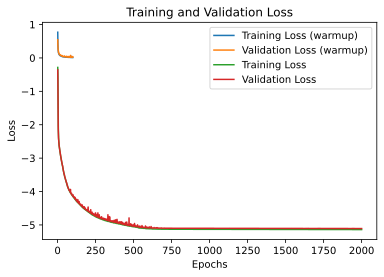

In [93]:
# Access the loss values from the training history.
train_loss_warmup = history_warmup.history['loss']
val_loss_warmup = history_warmup.history['val_loss']
train_loss_het = history_het.history['loss']
val_loss_het = history_het.history['val_loss']

# Create a plot of the training and validation loss over epochs.
epochs = range(1, len(train_loss_warmup) + 1)
plt.plot(epochs, train_loss_warmup, label='Training Loss (warmup)')
plt.plot(epochs, val_loss_warmup, label='Validation Loss (warmup)')
epochs = range(1, len(train_loss_het) + 1)
plt.plot(epochs, train_loss_het, label='Training Loss')
plt.plot(epochs, val_loss_het, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0,0.01)
plt.legend()

In [94]:
amp_pred_het = np.array(
    destandardize(model_het.predict(mominv_test_stdized), amp_ave, amp_std)
)

3125/3125 [==============================] - 2s 742us/step


In [95]:
amp_test[0], amp_pred[0], amp_pred_het[0,0]

(0.027657221661074937, 0.02830955, 0.027341327)

In [96]:
amp_test[1], amp_pred[1], amp_pred_het[0,1]

(0.013374394357415678, 0.012464734, -0.95355916)

In [97]:
0, amp_pred_err[0], amp_pred_het[0,1]

(0, 0.009005995, -0.95355916)

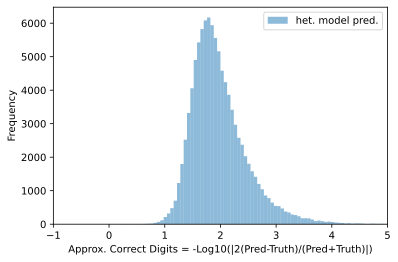

In [98]:
acc_het = 2.*(amp_pred_het[:,0]-amp_test)/(amp_pred_het[:,0]+amp_test)
logacc_het = -np.log10(abs(acc_het))

mybins = np.histogram_bin_edges(logacc_het, bins=100, range=(-1,5))
plt.hist(logacc_het, density=False, bins=mybins, alpha=0.5, label='het. model pred.')
plt.xlim([-1,5])
plt.xlabel('Approx. Correct Digits = -Log10(|2(Pred-Truth)/(Pred+Truth)|)')
plt.ylabel('Frequency');
plt.legend()

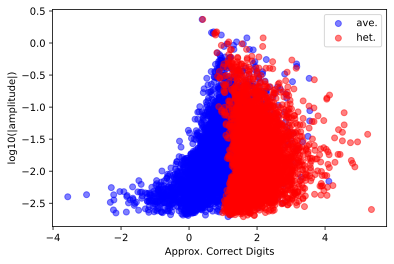

In [99]:
idx = np.random.choice(len(amp_test), size=5000, replace=False)

plt.scatter(logacc[idx],np.log10(np.abs(amp_test[idx])),color='blue',alpha=0.5, label='ave.')
plt.scatter(logacc_het[idx],np.log10(np.abs(amp_test[idx])),color='red',alpha=0.5, label='het.')
plt.xlabel('Approx. Correct Digits')
plt.ylabel('log10(|amplitude|)');
plt.legend()